In [1]:
# filtered or not
# word2vec choice
# with images or not.
# pca


# main function is f(user, business)
# user2avgVec # inclusive of current business
# user2avgHistVec # exclusive of current business
# business2avgVec # inclusive of current user
# business2avgHistVec # exclusive of current user

# with or without t filtered json?
# with or without currents?
# with or without pics?

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import os
from collections import defaultdict
from bs4 import BeautifulSoup  
import requests
import zipfile
import io
import nltk
from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer
#from nltk.tokenize import word_tokenize
nltk.download('stopwords')

#import geopandas as gpd|
#import shapely
import gensim
import tqdm
import tensorflow as tf
import keras

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import SpectralEmbedding

# Load the Drive helper and mount
#from google.colab import drive
#mounted_path_folder = '/content/drive'
#drive.mount(mounted_path_folder, force_remount=True)

import sys
path_folder = "/content/drive/MyDrive/dsprojects/dsproject_grev/" # parent of current src folder
path_folder = (os.path.abspath(os.path.join((os.path.abspath(os.path.join(os.getcwd(), os.pardir))),os.pardir)))
sys.path.insert(0, path_folder+"/src/features/")
import util

from word2vec_recipe import *


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Benson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Benson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from keras.applications.vgg16 import VGG16
#vggnet_model = VGG16()
url_header_pics = "https://lh5.googleusercontent.com/p/"
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

from PIL import Image
import requests
from io import BytesIO

path_file_name = os.path.join(path_folder, "data", "temp","business_user2picVec.pkl")

import string

stop_words = stopwords.words('english')

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import tqdm

In [7]:
path_folder = "/content/drive/MyDrive/dsprojects/dsproject_grev/" # parent of current src folder
path_folder = (os.path.abspath(os.path.join((os.path.abspath(os.path.join(os.getcwd(), os.pardir))),os.pardir)))


In [8]:
import pickle

vocab_column_names = ["ingredients"]+["name"]
file_name_word2vec = "word2vec_"+("_".join(vocab_column_names))+".pkl"
path_file_word2vec = os.path.join(path_folder, "data","temp",file_name_word2vec)
with open(path_file_word2vec, "rb") as f:
    recipe_word2vec = pickle.load(f)

vocab_column_names = ["ingredients"]#+["name"]
file_name_tfidf = "tfidf_"+("_".join(vocab_column_names))+".pkl"
path_file_tfidf = os.path.join(path_folder, "data","temp",file_name_tfidf)
with open(path_file_tfidf, "rb") as f:
    recipe_tfidf = pickle.load(f)

DATASET_VERSION = ["FULL", "FILTER"][0]  
DROP_ONE_TIME_APPEARANCES = True
DROP_SEPARATED_ONE_TIME_APPEARANCES = False
USING_PICS = False

if DATASET_VERSION == "FILTER":
    path_folder_data = os.path.join(path_folder,"data","raw","filter_all_t.json")
else:
    path_folder_data = os.path.join(path_folder,"data","raw","image_review_all.json")

In [9]:
data = []
with open(path_folder_data) as f:
    for line in tqdm.tqdm(f):
        data.append(eval(line))
    f.close()

1487747it [03:47, 6552.90it/s]


In [10]:
# Filter or Full
# Pics or no Pics
# Drop one-time-appearing business_ids/user_ids: (seperately, or conjoined?) (for example, the business_id is 1-time, but the user_id has already appeared many times before)

In [11]:
if DATASET_VERSION == "FILTER":
    train_reviews = (data[0]["train"])
    test_reviews = (data[0]["test"])
else:
    train_reviews = data
# 3 tables:
# 1 for business_id, user_id, review_text, rating
# 1 for pics: business_id, user_id, pic
# 1 for external history review: business_id, user_id, review_text

#reviews_df = pd.DataFrame(data=None, columns=["business_id","user_id","rating","review_text"])
#history_reviews_df = pd.DataFrame(data=None, columns=["business_id","user_id","review_text"])
#pics_df = pd.DataFrame(data=None, columns=["business_id","user_id","pics"])

reviews_df_business_id_column_list = []
reviews_df_user_id_column_list = []
reviews_df_rating_column_list = []
reviews_df_review_text_column_list = []

history_reviews_df_business_id_column_list = []
history_reviews_df_user_id_column_list = []
history_reviews_df_review_text_column_list = []

pics_df_business_id_column_list = []
pics_df_user_id_column_list = []
pics_df_pics_column_list = []


for review in tqdm.tqdm(train_reviews):
    temp_business_id = None
    temp_user_id = None
    temp_rating = None
    temp_review_text = None
    temp_pics = None
    temp_history_reviews = None

    if "business_id" in review:
        temp_business_id = review["business_id"]
    if "user_id" in review:
        temp_user_id = review["user_id"]
    if "rating" in review:
        temp_rating = review["rating"]
    if "review_text" in review:
        temp_review_text = review["review_text"]
    if "pics" in review:
        temp_pics = review["pics"]
        if DATASET_VERSION == "FULL":
             temp_pics = [x["id"] for x in (temp_pics)]
    if "history_reviews" in review:
        temp_history_reviews = review["history_reviews"]
    
    reviews_df_business_id_column_list.append(temp_business_id)
    reviews_df_user_id_column_list.append(temp_user_id)
    reviews_df_rating_column_list.append(temp_rating)
    reviews_df_review_text_column_list.append(temp_review_text)

    if USING_PICS == True:
        if (temp_pics is None)==False:
            temp_pics_len = len(temp_pics)
            pics_df_business_id_column_list.extend([temp_business_id for _ in range(temp_pics_len)])
            pics_df_user_id_column_list.extend([temp_user_id for _ in range(temp_pics_len)])
            pics_df_pics_column_list.extend(temp_pics)

    #if (temp_history_reviews is None)==False:
    #    temp_history_reviews_len = len(temp_history_reviews)
    #    history_reviews_df_business_id_column_list.extend([x[0].split("_")[1] for x in temp_history_reviews])
    #    history_reviews_df_user_id_column_list.extend([temp_user_id for _ in range(temp_history_reviews_len)])
    #    history_reviews_df_review_text_column_list.extend([x[1] for x in temp_history_reviews])


reviews_df = pd.DataFrame()
reviews_df["business_id"] = reviews_df_business_id_column_list
reviews_df["user_id"] = reviews_df_user_id_column_list
reviews_df["rating"] = reviews_df_rating_column_list
reviews_df["review_text"] = reviews_df_review_text_column_list

#history_reviews_df = pd.DataFrame()
#history_reviews_df["business_id"] = history_reviews_df_business_id_column_list
#history_reviews_df["user_id"] = history_reviews_df_user_id_column_list
#history_reviews_df["review_text"] = history_reviews_df_review_text_column_list
if USING_PICS == True:
    pics_df = pd.DataFrame()
    pics_df["business_id"] = pics_df_business_id_column_list
    pics_df["user_id"] = pics_df_user_id_column_list
    pics_df["pics"] = pics_df_pics_column_list


100%|████████████████████████████████████████████████████████████████████| 1487747/1487747 [00:10<00:00, 147777.41it/s]


In [12]:
from sklearn.preprocessing import LabelEncoder

business_id_label_encoder = LabelEncoder()
user_id_label_encoder = LabelEncoder()

business_id_label_encoder.fit(reviews_df["business_id"])
user_id_label_encoder.fit(reviews_df["user_id"])

reviews_df["business_id"] = business_id_label_encoder.transform(reviews_df["business_id"])
reviews_df["user_id"] = user_id_label_encoder.transform(reviews_df["user_id"])

In [13]:
del data
del reviews_df_business_id_column_list
del reviews_df_user_id_column_list
del reviews_df_rating_column_list
del reviews_df_review_text_column_list
del train_reviews

In [14]:
# pretend the filt was stacked with train test and pics words added already

In [15]:
def clean_text_column(text_column):
    non_alphanumeric = string.punctuation # constant
    text_column = text_column.str.lower()
    text_column = text_column.str.translate(str.maketrans(non_alphanumeric, " "*len(non_alphanumeric)))
    return text_column

In [16]:
temp_df = reviews_df
temp_df["review_id"] = np.arange(temp_df.shape[0])
id_df = temp_df[["user_id","business_id","review_id"]]
review_df = temp_df[["review_id","review_text"]]

In [17]:
review_df["review_text"] = clean_text_column(review_df["review_text"]).str.split(" ")

In [18]:
reviewTextWords_df = review_df.explode("review_text")

In [20]:
len(reviewTextWords_df)

43678604

In [ ]:
reviewTextWords_df = reviewTextWords_df[~(reviewTextWords_df["review_text"].isin(stop_words))]
reviewTextWords_df = reviewTextWords_df[(reviewTextWords_df["review_text"].isin(recipe_word2vec.wv.vocab))]
reviewTextWords_df = reviewTextWords_df[(reviewTextWords_df["review_text"].isin(recipe_tfidf.vocab2idx))]
reviewTextWords_df = reviewTextWords_df[(reviewTextWords_df["review_text"] != "")]

In [ ]:
review_df = review_df[(review_df["review_id"].isin(pd.unique(reviewTextWords_df["review_id"])))]
# Remove double singletons


business_id_frequency = id_df.groupby(["business_id"],as_index=False)["business_id"].count()
user_id_frequency = id_df.groupby(["user_id"],as_index=False)["user_id"].count()
one_time_business_id_list = business_id_frequency[business_id_frequency["count"] == 1]["business_id"]
one_time_user_id_list = user_id_frequency[user_id_frequency["count"] == 1]["user_id"]

if DROP_ONE_TIME_APPEARANCES == True:
    id_df = id_df[
        ~( (id_df["business_id"].isin(one_time_business_id_list)) & (id_df["user_id"].isin(one_time_user_id_list)))
    ]
del business_id_frequency
del user_id_frequency
del one_time_business_id_list
del one_time_user_id_list

In [ ]:
vocab = [word for word in recipe_word2vec.wv.vocab
         if ((word in recipe_tfidf.vocab2idx) and (word not in stop_words))
        ]
vecs = [recipe_word2vec.wv[word] for word in vocab]
word2vec_df = pd.DataFrame()
word2vec_df["review_text"] = vocab
word2vec_df["vec"] = vecs

In [ ]:
reviewTextWords_df["word_count"] = 1

In [ ]:
reviewTextWord2vec_df = reviewTextWords_df.merge(word2vec_df, on=["review_text"])

reviewTextWord2vec_df.sort_values(["review_id"], inplace=True)

In [ ]:
reviewTextWord2vec_df_agg = (
    reviewTextWord2vec_df.groupby(["review_id"], as_index=False).agg(
        {"vec": list, "word_count": np.sum})
)
reviewTextWord2vec_df_agg["vec"] = reviewTextWord2vec_df_agg["vec"].apply(lambda x: np.sum(np.array(x), axis=0))

In [ ]:
id_review_df = id_df.merge(reviewTextWord2vec_df_agg, on=["review_id"])

np.max(id_review_df["vec"].apply(lambda x: np.max(np.abs(x)))/id_review_df["word_count"])

In [ ]:
id_review_df_agg_user = (
    id_review_df.groupby(["user_id"], as_index=False).agg(
        {"vec": list, "word_count": np.sum})
)
id_review_df_agg_user["vec"] = id_review_df_agg_user["vec"].apply(lambda x: np.sum(np.array(x), axis=0))

assert id_review_df_agg_user.shape[0] == 29585

In [ ]:
id_review_df_agg_business = (
    id_review_df.groupby(["business_id"], as_index=False).agg(
        {"vec": list, "word_count": np.sum})
)
id_review_df_agg_business["vec"] = id_review_df_agg_business["vec"].apply(lambda x: np.sum(np.array(x), axis=0))

assert id_review_df_agg_business.shape[0] == 27734

In [ ]:
id2vec_df = id_review_df.copy()
id2vec_df = id2vec_df.rename(columns={"vec": "vec_curr", "word_count": "word_count_curr"})

In [ ]:
assert np.mean(id2vec_df["word_count_curr"]>0) > 0

In [ ]:
id2vec_df = id2vec_df.merge(id_review_df_agg_user, on=["user_id"])
id2vec_df["vec"] -= id2vec_df["vec_curr"]
id2vec_df["word_count"] -=id2vec_df["word_count_curr"]
id2vec_df = id2vec_df.rename(columns={"vec": "user_vec", "word_count": "user_word_count"})
id2vec_df["user_vec"] /= id2vec_df["user_word_count"]
id2vec_df = id2vec_df[id2vec_df["user_word_count"] != 0]

In [ ]:
id2vec_df = id2vec_df.merge(id_review_df_agg_business, on=["business_id"])
id2vec_df["vec"] -= id2vec_df["vec_curr"]
id2vec_df["word_count"] -= id2vec_df["word_count_curr"]
id2vec_df = id2vec_df.rename(columns={"vec": "business_vec", "word_count": "business_word_count"})
id2vec_df["business_vec"] /= id2vec_df["business_word_count"]
id2vec_df = id2vec_df[id2vec_df["business_word_count"] != 0]

#np.max(id2vec_df["user_vec"].apply(lambda x: np.max(np.abs(x)))/id2vec_df["user_word_count"])

#np.max(id2vec_df["business_vec"].apply(lambda x: np.max(np.abs(x)))/id2vec_df["business_word_count"])

In [ ]:

id2vec_df = id2vec_df.drop(columns=["vec_curr","word_count_curr","user_word_count","business_word_count"])
concat_vecs = (
    id2vec_df["user_vec"].apply(list) + id2vec_df["business_vec"].apply(list)
)
train_X_curr_excluded_from_average = np.array(concat_vecs.values.tolist())
train_y_curr_excluded_from_average = np.ones(train_X_curr_excluded_from_average.shape[0])

#np.max(train_X_curr_excluded_from_average)

In [ ]:
np.max(id_review_df_agg_user["vec"].apply(lambda x: np.max(np.abs(x)))/id_review_df_agg_user["word_count"])

In [ ]:
np.max(id_review_df_agg_business["vec"].apply(lambda x: np.max(np.abs(x)))/id_review_df_agg_business["word_count"])

In [ ]:

id_review_df_agg_user["vec"] /= id_review_df_agg_user["word_count"]
id_review_df_agg_business["vec"] /= id_review_df_agg_business["word_count"]

user_mapper = id_review_df_agg_user[["user_id","vec"]].set_index("user_id")["vec"].to_dict()
business_mapper = id_review_df_agg_business[["business_id", "vec"]].set_index("business_id")["vec"].to_dict()

valid_user_id_column = id2vec_df["user_id"].values.tolist()
valid_business_id_column = id2vec_df["business_id"].values.tolist()
#valid_user_id_column = id_review_df["user_id"].values.tolist()
#valid_business_id_column = id_review_df["business_id"].values.tolist()

pair_existence_checker = defaultdict(lambda: -1)
for pair in list(zip(valid_user_id_column,valid_business_id_column)):
    pair_existence_checker[pair] = 1

In [ ]:
#len(pd.unique(valid_user_id_column)),len(pd.unique(valid_business_id_column))

In [ ]:
#len(pd.unique(valid_user_id_column)),len(pd.unique(valid_business_id_column))

In [ ]:
# len(pd.unique(valid_user_id_column)), should be 28835
# len(pd.unique(valid_business_id_column)), should be 15285

In [ ]:
# Unseen sampling (PCA verifies that this is a valid operation)
non_existing_interaction_pairs = []
pair_non_existence_checker = defaultdict(lambda: -1)

sampled_user_id_list = np.random.choice(valid_user_id_column, size=len(set(valid_user_id_column)))
business_id_list_ = list(set(valid_business_id_column)).copy()

business_amount_per_user = train_X_curr_excluded_from_average.shape[0] // (len(set(valid_user_id_column)))

max_sampling_amounts = [
    #np.floor(business_amount_per_user), 
    np.ceil(business_amount_per_user)
    ]
train_X_averages_with_curr_bc_unseen = []
train_y_averages_with_curr_bc_unseen = []
concat_embeddings_maxes = []
for temp_user_id in tqdm.tqdm(sampled_user_id_list):
    sampled_amount = 0
    business_id_iterator = 0
    np.random.shuffle(business_id_list_)
    max_sampling_amount = np.random.choice(max_sampling_amounts)
    while sampled_amount < max_sampling_amount:
        temp_business_id = business_id_list_[business_id_iterator]
        pair = [temp_user_id, temp_business_id]
        if ((pair_existence_checker[tuple(pair)] == -1) and (pair_non_existence_checker[tuple(pair)] == -1)):
            pair_non_existence_checker[tuple(pair)] = 1
            #non_existing_interaction_pairs.append(pair)
            concat_embeddings = list(user_mapper[temp_user_id]) + list(business_mapper[temp_business_id])
            train_X_averages_with_curr_bc_unseen.append(concat_embeddings)
            train_y_averages_with_curr_bc_unseen.append(0)
            sampled_amount += 1
        business_id_iterator += 1
assert all([(pair_existence_checker[tuple(pair)]==-1) for pair in non_existing_interaction_pairs])

train_X_averages_with_curr_bc_unseen = np.array(train_X_averages_with_curr_bc_unseen)
train_y_averages_with_curr_bc_unseen = np.array(train_y_averages_with_curr_bc_unseen)

In [ ]:
existing_interaction_pairs = train_X_curr_excluded_from_average
non_existing_interaction_pairs = train_X_averages_with_curr_bc_unseen
train_X_seen = train_X_curr_excluded_from_average
train_X_unseen = train_X_averages_with_curr_bc_unseen
train_y_seen = train_y_curr_excluded_from_average
train_y_unseen = train_y_averages_with_curr_bc_unseen

train_dataset_size = len(existing_interaction_pairs)+len(non_existing_interaction_pairs)
train_dataset_indexer = np.arange(train_dataset_size)
np.random.shuffle(train_dataset_indexer)

train_X = np.vstack((train_X_curr_excluded_from_average,train_X_averages_with_curr_bc_unseen))
train_y = np.hstack((train_y_curr_excluded_from_average,train_y_averages_with_curr_bc_unseen))

train_X = train_X[train_dataset_indexer]
train_y = train_y[train_dataset_indexer]
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.25)

In [ ]:
pca = PCA(2)
temp_X_pca_input = train_X
temp_y_pca_input = train_y

Z = pca.fit_transform(temp_X_pca_input)
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(Z[:,0], Z[:,1],c=temp_y_pca_input, alpha=0.1, s=5, cmap="winter")

In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=500, class_weight="balanced", C=0.5)
log_reg.fit(X_train, y_train)
lr_y_pred = log_reg.predict(X_val)

y_true = y_val
y_pred = lr_y_pred
conf_matrix = confusion_matrix(y_true, y_pred,normalize="true")
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(conf_matrix, annot=True) #notation: "annot" not "annote"
y_lims = ax.get_ylim()
ax.set_ylim(sum(y_lims), 0)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_y_pred = dt.predict(X_val)

y_true = y_val
y_pred = lr_y_pred
conf_matrix = confusion_matrix(y_true, y_pred,normalize="true")
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(conf_matrix, annot=True) #notation: "annot" not "annote"
y_lims = ax.get_ylim()
ax.set_ylim(sum(y_lims), 0)

In [34]:
model = Sequential()
model.add(Dense(50, input_shape=(train_X.shape[1],), activation='relu'))
model.add(Dense(100, activation='relu'))
#model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=100)

Epoch 1/5
11795/11795 [==============================] - 30s 3ms/step - loss: 0.6041 - accuracy: 0.6731
Epoch 2/5
11795/11795 [==============================] - 29s 2ms/step - loss: 0.5812 - accuracy: 0.6955
Epoch 3/5
11795/11795 [==============================] - 29s 2ms/step - loss: 0.5739 - accuracy: 0.7018
Epoch 4/5
11795/11795 [==============================] - 29s 2ms/step - loss: 0.5697 - accuracy: 0.7049
Epoch 5/5
11795/11795 [==============================] - 29s 2ms/step - loss: 0.5665 - accuracy: 0.7075


12286/12286 [==============================] - 16s 1ms/step
Val Loss:  0.5676828026771545 , Test Accuracy:  0.7068740725517273


(2.0, 0)

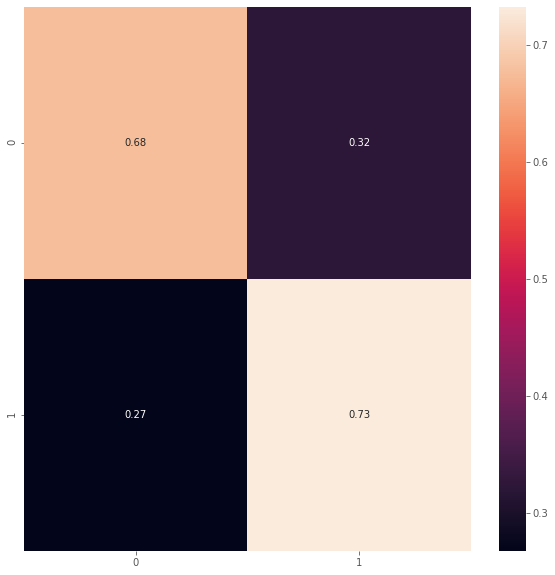

In [35]:
val_loss, val_acc = model.evaluate(X_val, y_val)
predictions = model.predict(X_val)

#assert np.all(predictions >= 0)
#assert np.all(predictions <= 1)
#accuracy = np.mean(y_val==np.squeeze((predictions >= 0.5).astype(int)))

print("Val Loss: ", val_loss, ", Test Accuracy: ", val_acc)
y_true = y_val
y_pred = np.squeeze((predictions >= 0.5).astype(int))
conf_matrix = confusion_matrix(y_true, y_pred,normalize="true")
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(conf_matrix, annot=True) #notation: "annot" not "annote"
y_lims = ax.get_ylim()
ax.set_ylim(sum(y_lims), 0)

# VISUALIZATION ONLY

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
def plot_silhoutte_scores(embeddings):
    range_n_clusters = [20, 50, 100, 250, 500, 1000]
    silhouette_avg = []
    for num_clusters in tqdm.tqdm(range_n_clusters):   
        # initialise kmeans
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(embeddings)
        cluster_labels = kmeans.labels_
        
        # silhouette score
        score = silhouette_score(embeddings, cluster_labels)
        silhouette_avg.append(score)
        print(score)
    plt.plot(range_n_clusters,silhouette_avg,'bx-')
    plt.xlabel('Values of K') 
    plt.ylabel('Silhouette score') 
    plt.title('Silhouette analysis For Optimal k')
    plt.show()
# plot_silhoutte_scores(user_embeddings)
# silhoutte scores reveal that user_embeddings is poor to k-means cluster on (highly overlapped): increasing K worsens the silhoutte score

In [ ]:
your_word_vector = business_embeddings[0]
recipe_word2vec.most_similar(positive=[your_word_vector], topn=1)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def clean_text_column(text_column):
    non_alphanumeric = string.punctuation # constant
    text_column = text_column.str.lower()
    text_column = text_column.str.translate(str.maketrans(non_alphanumeric, " "*len(non_alphanumeric)))
    return text_column

In [ ]:
i = 17
# 10
print("Business id:", i)
print(recipe_word2vec.most_similar(positive=[business_embeddings[i]], topn=1)[0][0])
def get_words_of_business_id(business_id):
    business_id_df = reviews_df[reviews_df["business_id"]==business_id]
    review_text_column = business_id_df["review_text"]
    review_text_column = clean_text_column(review_text_column)
    review_text_column = review_text_column.apply(
        lambda x: " ".join([
            word for word in x.split(" ") 
            if word in recipe_tfidf.vocab2idx
            ])+" ")
    review_text = review_text_column.values.sum()
    review_text_set = pd.Series(review_text.split(" ")).value_counts()
    review_text_set
    print(review_text_set)

get_words_of_business_id(business_id_list[i])

In [ ]:
i = 0
print("The representative word for Restaurant", business_id_list[i], "is :\n", 
      recipe_word2vec.most_similar(positive=[business_embeddings[i]], topn=1)[0][0])
print("\nThe reviews for this restaurant are as follows:\n")
(reviews_df[reviews_df["business_id"]==business_id_list[i]]["review_text"])

In [ ]:
from sklearn.cluster import DBSCAN
eps = 3
min_samples = 1
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(business_embeddings)
business_labels = dbscan.labels_
print(len((business_labels)))
assert len(business_id_list) == len(business_labels)
print(len(set(business_labels)))

eps = 3
min_samples = 1
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(user_embeddings)
user_labels = dbscan.labels_
print(len((user_labels)))
assert len(user_id_list) == len(user_labels)

print(len(set(user_labels)))

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
business_embeddings_ = StandardScaler().fit_transform(business_embeddings)
user_embeddings_ = StandardScaler().fit_transform(user_embeddings)
pca = PCA(50)
tsne = TSNE(n_components=2, perplexity=100, n_iter=250)
Z_business = business_embeddings_
Z_business = pca.fit_transform(Z_business)
Z_business = tsne.fit_transform(Z_business)
#Z_business = umap0.fit_transform(Z_business)

pca = PCA(50)
tsne = TSNE(n_components=2, perplexity=100, n_iter=250)
Z_user = user_embeddings_
Z_user = pca.fit_transform(Z_user)
Z_user = tsne.fit_transform(Z_user)
#Z_user = umap0.fit_transform(Z_user)

In [ ]:

fig, axs = plt.subplots(1, 2, figsize=(20,10))
axs[0].scatter(Z_business[:,0], Z_business[:,1], alpha=0.5,s=1, c=business_labels,cmap="Spectral")
axs[0].set_title("Business Embeddings")
#from matplotlib import cm
#colormap = cm.hsv(range(20))


axs[1].scatter(Z_user[:,0], Z_user[:,1], alpha=0.5,s=1, c=user_labels,cmap="Spectral")#, label=word_labels)
axs[1].set_title("User Embeddings")
#axs[1].legend()

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(10)
kmeans.fit(business_embeddings)
business_labels = kmeans.labels_
print(len((business_labels)))
print(len(set(business_labels)))

kmeans = KMeans(20)
kmeans.fit(user_embeddings)
user_labels = kmeans.labels_
print(len((user_labels)))
print(len(set(user_labels)))
fig, axs = plt.subplots(1, 2, figsize=(20,10))
axs[0].scatter(Z_business[:,0], Z_business[:,1], alpha=0.5,s=1, c=business_labels,cmap="tab10")
axs[0].set_title("Business Embeddings")
#from matplotlib import cm
#colormap = cm.hsv(range(20))


axs[1].scatter(Z_user[:,0], Z_user[:,1], alpha=0.5,s=1, c=user_labels,cmap="tab20")#, label=word_labels)
axs[1].set_title("User Embeddings")
#axs[1].legend()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))
axs[0].scatter(Z_business[:,0], Z_business[:,1], alpha=0.5,s=1, c='r',cmap="tab10")
axs[0].set_title("Business Embeddings")
#from matplotlib import cm
#colormap = cm.hsv(range(20))


axs[1].scatter(Z_user[:,0], Z_user[:,1], alpha=0.5,s=1, c='r',cmap="tab20")#, label=word_labels)
axs[1].set_title("User Embeddings")

In [ ]:
def get_label_data(labels, id_list, id2vec, id_column_name, reviews_df):
    labels_set = set(labels)
    labels_representative_words = []
    labels_representative_embeddings = []
    labels_vocab_frequency = []
    for label in labels_set:
        temp_idxs = np.where(np.array(labels)==label)[0]
        embeddings_group = []
        group_vocab = " "
        for temp_idx in temp_idxs:
            temp_id = id_list[temp_idx]
            #for key in id2vec[temp_id]: embeddings_group += id2vec[(id_list[temp_idx])][key];
            ##
            temp_id_df = reviews_df[reviews_df[id_column_name]==temp_id]
            review_text_column = temp_id_df["review_text"]
            review_text_column = clean_text_column(review_text_column)
            review_text_column = review_text_column.apply(
                lambda x: " ".join([
                    word for word in x.split(" ") 
                    if word in recipe_tfidf.vocab2idx
                    ])+" ")
            
            combined_review_texts_of_id = review_text_column.values.sum() # get all re
            group_vocab += (combined_review_texts_of_id+" ")
            ##
        group_vocab_list = group_vocab.split(" ")
        group_vocab_list = [word for word in group_vocab_list if word != ""]
        group_vocab_frequency = pd.Series(group_vocab_list).value_counts()
        labels_vocab_frequency.append(group_vocab_frequency)


        #embeddings_group = np.array(embeddings_group)
        #labels_representative_embedding = embeddings_group.mean(axis=0)
        #labels_representative_embeddings.append(labels_representative_embedding)

        #labels_representative_word = recipe_word2vec.most_similar(positive=[labels_representative_embedding], topn=1)
        #labels_representative_words.append(labels_representative_word[0][0])


    return labels_set, labels_representative_words, labels_representative_embeddings, labels_vocab_frequency
#output_labels_data = get_label_data(business_labels, business_id_list, business_user2reviewTextVec, "business_id", reviews_df)
#labels_set, labels_representative_words, labels_representative_embeddings, labels_vocab_frequency = output_labels_data

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

import scipy

In [ ]:
learned_mapping = dict(zip(list(recipe_tfidf.vocab2idx.keys()),list(range(len(recipe_tfidf.vocab2idx)))))

In [ ]:
label_column_name = "business_label"
business_labeler = pd.DataFrame()
business_labeler[label_column_name] = business_id_list
business_labeler[label_column_name] = business_labels
temp_reviews_df = reviews_df.merge(business_labeler, on=[label_column_name])

In [ ]:
label_column_name = "user_label"
user_labeler = pd.DataFrame()
user_labeler["user_id"] = user_id_list
user_labeler[label_column_name] = user_labels
temp_reviews_df = reviews_df.merge(user_labeler, on=["user_id"])

In [ ]:
### Move to Vectorizer_Builder (collapser version 1)
learned_mapping = dict(zip(list(recipe_tfidf.vocab2idx.keys()),list(range(len(recipe_tfidf.vocab2idx)))))

temp_labels = list(pd.unique(temp_reviews_df[label_column_name]))

review_text_column_ = []

for label in temp_labels:
    label_all_text = ""
    temp_reviews_df_label = temp_reviews_df[temp_reviews_df[label_column_name]==label]
    temp_review_text_column = temp_reviews_df_label["review_text"]
    temp_review_text_column = clean_text_column(temp_review_text_column)
    for row in tqdm.tqdm(list(temp_review_text_column.values)):
        label_all_text += (" "+row)
    review_text_column_.append(label_all_text)
learned_tv = Pipeline([('count', CountVectorizer(vocabulary=learned_mapping)),
                       ('tfidf', TfidfTransformer())])
learned_tv.fit(review_text_column_)
tv_output_collapsed = learned_tv.transform(review_text_column_)
#tv_output_collapsed = tv_output_collapsed.tocsc().A

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_top_n_from_vector(feature_names, sorted_items, top_n=10):
    sorted_items = sorted_items[:top_n]
    
    score_vals = []
    feature_vals = []
    for idx, score in sorted_items:
        score_vals.append(round(score,3))
        feature_vals.append(feature_names[idx])
    results = {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]] = score_vals[idx]
    return results

In [ ]:
# Now doing USERS!

In [ ]:
feature_names = learned_tv.named_steps["count"].get_feature_names()
i = 19
print("Group", temp_labels[i], "Keywords:" )
output_label_temp = learned_tv.transform([review_text_column_[i]])
sorted_items = sort_coo(output_label_temp.tocoo())
keywords = extract_top_n_from_vector(feature_names, sorted_items, 50)
keywords
# 7 = pizza, italian
# 4 = sweets (chocolate, cookies, cake, cream)
# 5 = seafood?

# user7 = asian
# user0 = sweets

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
a = np.array([
    [0.090909, 0.1111111, 0.5],
    [0.090909, 0, 0],
    [0.11111111, 0, 0],
    [0.11111111, 0, 0],
    [0.11111111, 0.1818181818, 0],
    [0.11111111, 0.090909, 0],
    [0.25, 0, 0]
])
a_scaled = MinMaxScaler().fit_transform(a.T).T


In [ ]:
a_scaled

In [ ]:
np.std(a_scaled,axis=1,ddof=0)

In [ ]:
### Move to Vectorizer_Builder (collapser version 2)

#temp_reviews_df.sort_values(["business_label"],inplace=True)

temp_labels = list(pd.unique(temp_reviews_df[label_column_name]))

review_text_column = temp_reviews_df["review_text"]
review_text_column = clean_text_column(review_text_column)

learned_tv = Pipeline([('count', CountVectorizer(vocabulary=learned_mapping)),
                       ('tfidf', TfidfTransformer())])
learned_tv.fit(review_text_column)
tv_output = learned_tv.transform(review_text_column)

tv_output_collapsed = []
for temp_label in temp_labels:
    temp_label_tv_output_collapsed = tv_output[np.where(temp_reviews_df[label_column_name]==temp_label)[0]].mean(axis=0)
    tv_output_collapsed.append(np.squeeze(temp_label_tv_output_collapsed.A,0))
tv_output_collapsed = np.array(tv_output_collapsed)

In [ ]:
ind = np.argsort(tv_output_collapsed, axis=1)
[recipe_tfidf.idx2vocab[i] for i in ind[:,-1]]

In [ ]:
def get_label_data(labels, id_list, id2vec, id_column_name, reviews_df):
    labels_set = set(labels)
    labels_representative_words = []
    labels_representative_embeddings = []
    labels_vocab_frequency = []
    for label in labels_set:
        temp_idxs = np.where(np.array(labels)==label)[0]
        temp_ids = [id_list[temp_idx] for temp_idx in temp_idxs]
        temp_label_df = reviews_df[reviews_df[id_column_name].isin(temp_ids)]
        review_text_column = temp_label_df["review_text"]
        review_text_column = clean_text_column(review_text_column)
        learned_mapping = dict(zip(list(recipe_tfidf.keys()),list(range(len(recipe_tfidf)))))
        # learned_cv = CountVectorizer(vocabulary=learned_mapping)
        # cv_output = learned_cv.transform(review_text_column)
        # cv_output = cv_output.tocsc()
        # scipy.sparse.csc_matrix.sum(cv_output, axis=0)

        learned_tv = TfidfVectorizer(vocabulary=learned_mapping)
        tv_output = learned_tv.transform(review_text_column)
        tv_output.

        review_text_column
        for temp_idx in temp_idxs:
            temp_id = id_list[temp_idx]
            #for key in id2vec[temp_id]: embeddings_group += id2vec[(id_list[temp_idx])][key];
            ##
            temp_id_df = reviews_df[reviews_df[id_column_name]==temp_id]
            review_text_column = temp_id_df["review_text"]
            review_text_column = clean_text_column(review_text_column)
            review_text_column = review_text_column.apply(
                lambda x: " ".join([
                    word for word in x.split(" ") 
                    if word in recipe_tfidf.vocab2idx
                    ])+" ")
            
            combined_review_texts_of_id = review_text_column.values.sum() # get all re
            group_vocab += (combined_review_texts_of_id+" ")
            ##
        group_vocab_list = group_vocab.split(" ")
        group_vocab_list = [word for word in group_vocab_list if word != ""]
        group_vocab_frequency = pd.Series(group_vocab_list).value_counts()
        labels_vocab_frequency.append(group_vocab_frequency)


        #embeddings_group = np.array(embeddings_group)
        #labels_representative_embedding = embeddings_group.mean(axis=0)
        #labels_representative_embeddings.append(labels_representative_embedding)

        #labels_representative_word = recipe_word2vec.most_similar(positive=[labels_representative_embedding], topn=1)
        #labels_representative_words.append(labels_representative_word[0][0])


    return labels_set, labels_representative_words, labels_representative_embeddings, labels_vocab_frequency

In [ ]:
labels_set, labels_representative_words, labels_representative_embeddings = get_label_data(user_labels, user_id_list, user_business2reviewTextVec)
labels_representative_words

In [ ]:
temp_business_cluster_mapper = pd.DataFrame()
temp_business_cluster_mapper["business_id"] = business_id_list
temp_business_cluster_mapper["business_id_regrouped"] = business_labels

temp_user_cluster_mapper = pd.DataFrame()
temp_user_cluster_mapper["user_id"] = user_id_list
temp_user_cluster_mapper["user_id_regrouped"] = user_labels

temp_reviews_df = reviews_df.copy()
temp_reviews_df = temp_reviews_df.merge(temp_business_cluster_mapper, on=["business_id"])
temp_reviews_df = temp_reviews_df.merge(temp_user_cluster_mapper,  on=["user_id"])

temp_reviews_df = 

In [ ]:
temp_reviews_df

In [ ]:
# end goal (just for scatterplotting)
# create a 2D scatterplot from (PCA, TSNE)
# with grouped adjacent clusters (size>20, n_cluster<50) with representative word being adjacent
# these clusters need not be made after the creation of the 2D scatterplotting,
# for business and user (business easier, but user more useful)
#
# but how make words spacially logical? we have the pita-naan july4th word2vec model...
# given (for user or business) 
# # a bank of review sentences, clean, split, remove stop words, keep only food-related words (how do that? with just ingredients, or names too (introduces the risk of emotional words))
# given (for user or business) a bank of review sentences after data-cleaning, get a representative vector-point 
# # (which is then put through PCA/TSNE for a 2D scatterplot)
# cluster group these user businesses or vector points



# why do embeddings when words are faster 
# to embedding
# micro 
# # DBSCAN
# # Eventually, 2D
# macro 
# # 2D scatterplot (TSNE)
# # only here can tf-idf be applied